# 1. Bias mitigation algorithms (Pre-processing)

---

## 1-1. Disparate Impact Remover

### API Reference:
- https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.DisparateImpactRemover.html#aif360.algorithms.preprocessing.DisparateImpactRemover

### Related paper:
- [M. Feldman, S. A. Friedler, J. Moeller, C. Scheidegger, and S. Venkatasubramanian, “Certifying and removing disparate impact.” ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015.](https://dl.acm.org/doi/pdf/10.1145/2783258.2783311)

### Description
Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups. In other words, This algorithm corrects for imbalanced selection rates between unprivileged and privileged groups at various levels of repair.

---

## Load and preprocess a dataset

Use a [Adult](https://archive.ics.uci.edu/ml/datasets/adult) dataset and designate 'sex' attribute as a protected attribute.

In [16]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.metrics import BinaryLabelDatasetMetric

In [17]:
protected = 'sex'
ad = AdultDataset(protected_attribute_names=[protected],
    privileged_classes=[['Male']], categorical_features=[],
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

In [18]:
scaler = MinMaxScaler(copy=False)

test, train = ad.split([16281])
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)

index = train.feature_names.index(protected)

## Apply disparate impact remover to dataset 

Befor training the model, we apply the disparate impact remover to the dataset for unprotected attributes.

With the preprocessed dataset, we train the logistic regression model. Then we evaluate the fairness of the trained model by utilizing a metric called disparate impact.

In [19]:
DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    
    # Define disparate impact remover
    di = DisparateImpactRemover(repair_level=level)
    """
    fit_transform(): Run a repairer on the non-protected 
    features and return the transformed dataset.
    """
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:24<00:00,  2.23s/it]


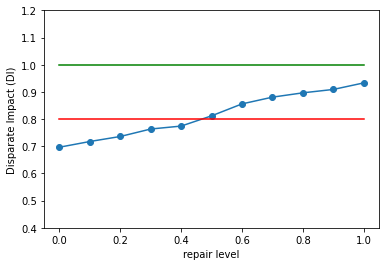

In [20]:
plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

---

## 1-2. Learning  Fair Representation (LFR)

### API Reference:
- https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.LFR.html#aif360.algorithms.preprocessing.LFR

### Related paper:
- [R. Zemel, Y. Wu, K. Swersky, T. Pitassi, and C. Dwork, “Learning Fair Representations.” International Conference on Machine Learning, 2013.](http://proceedings.mlr.press/v28/zemel13.pdf)

### Description
Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes. We will see how to use this algorithm for learning representations that encourage individual fairness and apply them on the Adult dataset.

---

In [5]:
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.lfr import LFR

from common_utils import compute_metrics

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from IPython.display import Markdown, display

## Load and preprocess a dataset 

In [6]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_adult()
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [7]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


## Check defference in mean outcomes of original dataset 

Before apply the LFR to the dataset, we first cehck the difference in mean outcomes between unpriviled and privileged groups.

In [8]:
# Metric for the original dataset
privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.194891


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.193703


## Apply and train LFR

In [9]:
scale_orig = StandardScaler()
dataset_orig_train.features = scale_orig.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = scale_orig.transform(dataset_orig_test.features)

In [10]:
# Input recontruction quality - Ax
# Fairness constraint - Az
# Output prediction error - Ay

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
    
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(dataset_orig_train, maxiter=5000, maxfun=5000)

step: 0, loss: 0.869991606614979, L_x: 2.5233946164181127,  L_y: 0.5888537110583112,  L_z: 0.01439921695742823
step: 250, loss: 0.8408228210444618, L_x: 2.5209558948188846,  L_y: 0.5605801246882377,  L_z: 0.014073553437167824
step: 500, loss: 0.819195746920744, L_x: 2.510898040679135,  L_y: 0.5425150331838887,  L_z: 0.012795454834470898
step: 750, loss: 0.8146857605092016, L_x: 2.5046102118328197,  L_y: 0.5401651518173829,  L_z: 0.01202979375426833
step: 1000, loss: 0.7644879410085512, L_x: 2.382467087271253,  L_y: 0.5164299105065167,  L_z: 0.0049056608874546645
step: 1250, loss: 0.7481232469063299, L_x: 2.3137060083932233,  L_y: 0.5061482714326258,  L_z: 0.005302187317190898
step: 1500, loss: 0.7230319613581802, L_x: 2.1733762705213073,  L_y: 0.49164887845127925,  L_z: 0.007022727927385078
step: 1750, loss: 0.6684616597489367, L_x: 1.8205278613352602,  L_y: 0.464465048521636,  L_z: 0.010971912546887293
step: 2000, loss: 0.6589948999164239, L_x: 1.7803258459569888,  L_y: 0.457650205393

In [11]:
# Transform training data and align features
dataset_transf_train = TR.transform(dataset_orig_train)
dataset_transf_test = TR.transform(dataset_orig_test)

In [12]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.037490


#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.028987


---
## 1-3. Optimized Preprocessing 

### API Reference:
- https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.OptimPreproc.html#aif360.algorithms.preprocessing.OptimPreproc

### Related paper:
- [F. P. Calmon, D. Wei, B. Vinzamuri, K. Natesan Ramamurthy, and K. R. Varshney. “Optimized Pre-Processing for Discrimination Prevention.” Conference on Neural Information Processing Systems, 2017.](https://proceedings.neurips.cc/paper/2017/file/9a49a25d845a483fae4be7e341368e36-Paper.pdf)

### Description
Optimized preprocessing is a preprocessing technique that learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and data fidelity constraints and objectives.

In [24]:
import numpy as np
from tqdm import tqdm

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

from sklearn.linear_model import LogisticRegression

## Load and preprocess dataset

In [25]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_adult(['sex'])

In [26]:
# Split into train, validation, and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [27]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


## Compute fairness metric on original training dataset

In [28]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.195878


## Apply the optimized preprocessing

Transform and train the original training dataset using the optimized preprocessing

In [29]:
optim_options = {
    "distortion_fun": get_distortion_adult,
    "epsilon": 0.05,
    "clist": [0.99, 1.99, 2.99],
    "dlist": [.1, 0.05, 0]
}
    
OP = OptimPreproc(OptTools, optim_options)

OP = OP.fit(dataset_orig_train)

dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)

dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use `

Optimized Preprocessing: Objective converged to 0.012697


In [30]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.048663


In the same manner, apply the optimized preprocessing to test data

In [42]:
dataset_orig_test = dataset_transf_train.align_datasets(dataset_orig_test)
display(Markdown("#### Testing Dataset shape"))
print(dataset_orig_test.features.shape)

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Testing Dataset shape

(7327, 18)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.191758


Transform the original test dataset and compute metric

In [43]:
dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)

metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.049971


## Train classifier on original data

To train the classifier, we use the logitstic regression model

In [44]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

In [45]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [49]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.7516
Optimal classification threshold (no fairness constraints) = 0.2476


### Predictions and fairness metrics from original test set

In [50]:
display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

display(Markdown("#### Testing set"))
display(Markdown("##### Raw predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                       unprivileged_groups, privileged_groups, disp=disp)
    
    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

#### Testing set

##### Raw predictions - No fairness constraints

 51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 51/100 [00:00<00:00, 250.96it/s]

Balanced accuracy = 0.7487
Statistical parity difference = -0.3646
Disparate impact = 0.2780
Average odds difference = -0.3141
Equal opportunity difference = -0.3606
Theil index = 0.1104


invalid value encountered in double_scalars
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 255.12it/s]


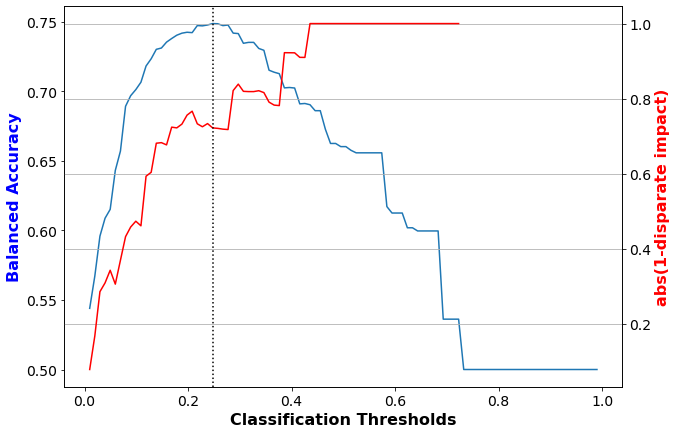

In [52]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_orig = np.abs(1.0-np.array(disp_imp_arr_orig))[best_ind]

#### `abs(1-disparate impact)` must be close to zero for classifier predictions to be fair.

## Train classifier on transformed data and obtain predictions with its fairness metric

In [55]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

### Predictions and fairness metrics from transformed test set

In [58]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
X_test = scale_transf.transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [59]:
display(Markdown("#### Predictions from transformed testing data"))

bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

display(Markdown("#### Testing set"))
display(Markdown("##### Transformed predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_transf_test, dataset_transf_test_pred, 
                                       unprivileged_groups, privileged_groups, disp=disp)
    
    bal_acc_arr_transf.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_bef["Disparate impact"])

#### Predictions from transformed testing data

#### Testing set

##### Transformed predictions - No fairness constraints

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 77/100 [00:00<00:00, 254.68it/s]

Balanced accuracy = 0.7158
Statistical parity difference = -0.0975
Disparate impact = 0.7624
Average odds difference = -0.0846
Equal opportunity difference = -0.1003
Theil index = 0.1281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 255.02it/s]


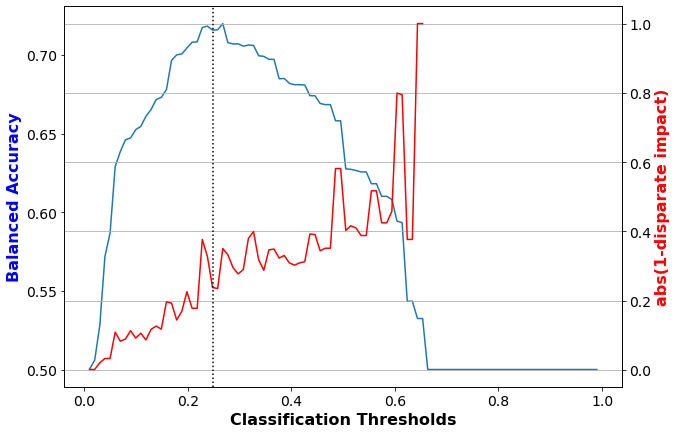

In [60]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

#### `abs(1-disparate impact)` must be close to zero for classifier predictions to be fair.

### This measure has improved using classifier trained using the transformed data compared to the original data.